In [14]:
import networkx as nx
import numpy as np
import pandas as pd


In [15]:
# Read in data
df = pd.read_csv("../../data/forwards/forwards_edgelist_corsi.csv")
players_df = pd.read_csv(
    "../../data/forwards/aggregate_forwards.csv", index_col='playerId', header=0)


In [16]:
# Graph with 2 edges per pairing
# Create a network of nodes which are players and the links are players that played together
# We create 2 graphs, one for each relationship direction and then compose them for our total graph
df = df.rename(columns={'cf_inf_on2': 'weight'})
G0 = nx.Graph()
G0 = nx.from_pandas_edgelist(df, 'playerId1', 'playerId2', [
                             'weight'], create_using=nx.DiGraph)

df = df.rename(columns={'weight': 'notweight', 'cf_inf_on1': 'weight'})
G1 = nx.Graph()
G1 = nx.from_pandas_edgelist(
    df, 'playerId2', 'playerId1', edge_attr='weight', create_using=nx.DiGraph)

G = nx.compose(G0, G1)

# remove isolates
G.remove_nodes_from(list(nx.isolates(G)))


In [17]:
interesting_stats = [
    'playerName',
    'games_played',
    'icetime',
    'timeOnBench',
    'onIce_corsiPercentage',
    'offIce_corsiPercentage',
    'on_off_corsi_diff',
    'OnIce_F_goals_per60',
    'OnIce_A_goals_per60',
    'I_F_dZoneGiveaways_per60',
    'I_F_giveaways_per60',
    'average_TOI',
    'I_F_hits_per60',
    'I_F_takeaways_per60',
    'I_F_points_per60',
    'shotsBlockedByPlayer_per60',
    'I_F_oZoneShiftStarts_per60',
    'I_F_dZoneShiftStarts_per60',
    'I_F_neutralZoneShiftStarts_per60',
    'I_F_flyShiftStarts_per60',
    'I_F_primaryAssists_per60',
    'I_F_secondaryAssists_per60',
    'I_F_goals_per60'
]


In [18]:
# Add data to nodes that may be useful for visualization
def copy_attr_to_nodes(G, df, attr_name):
    nodes_dict = dict.fromkeys(G.nodes)
    for node in G.nodes:
        node_attr = df.loc[[node]][attr_name].values[0]
        nodes_dict[node] = node_attr
    return nodes_dict


In [19]:
# Add player names to nodes
player_names = copy_attr_to_nodes(G, players_df, "playerName")
nx.set_node_attributes(G, player_names, "playerName")


In [20]:
# output a gephi file for ez visualization
nx.write_gexf(G, 'forwards.gexf')


In [21]:
# Number of nodes and edges
num_nodes = G.number_of_nodes()
num_edges = G.number_of_edges()
print("Number of nodes: ", num_nodes)
print("Number of edges: ", num_edges)


Number of nodes:  802
Number of edges:  7114


In [22]:
# Number of connected components
is_strongly_connected = nx.is_strongly_connected(G)
print("Is graph strongly connected? ", is_strongly_connected)
num_strongly_connected_components = nx.number_strongly_connected_components(G)
print("Number of strongly connected components: ",
      num_strongly_connected_components)
num_weakly_connected_components = nx.number_weakly_connected_components(G)
print("Number of weakly connected components: ",
      num_weakly_connected_components)


Is graph strongly connected?  False
Number of strongly connected components:  2
Number of weakly connected components:  2


In [23]:
# Average outgoing link weight. This determines which players had the greatest effect on their linemates
# Do total out degree as well
out_degrees = G.out_degree(weight="weight")
for player_out_degree in out_degrees:
    player_id = player_out_degree[0]
    avg_out_weight = player_out_degree[1] / G.out_degree(player_id)
    players_df.loc[player_id, "average_corsi_influence"] = avg_out_weight
    players_df.loc[player_id, "total_out_influence"] = player_out_degree[1]

output_file = '../../data/forwards/aggregate_forwards.csv'
players_df.to_csv(output_file)


In [24]:
# Correlations between stats. We are mainly interested in the correlation with average and total influence
players_df.corr(numeric_only=True, method='spearman').to_csv(
    "../../data/forwards/correlations.csv")


In [25]:
# drop some big outliers
players_df = players_df.drop([8470647, 8475794, 8475213, 8470775])


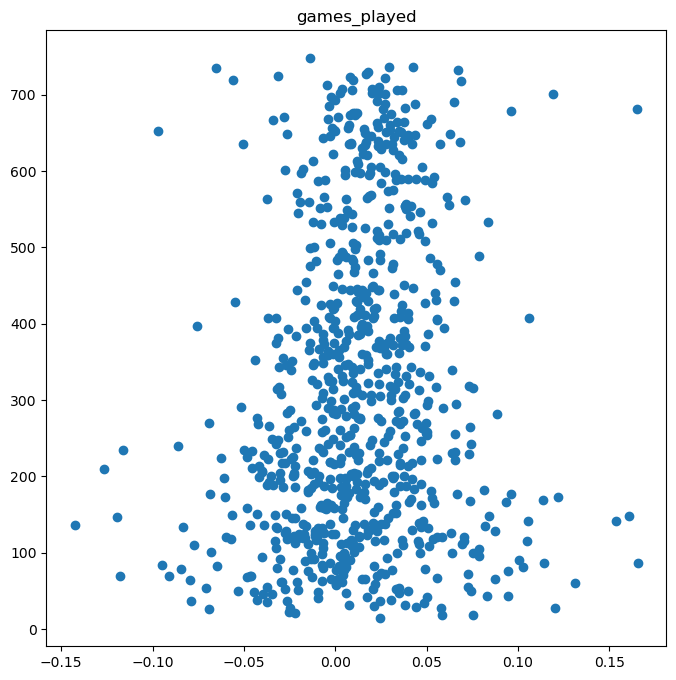

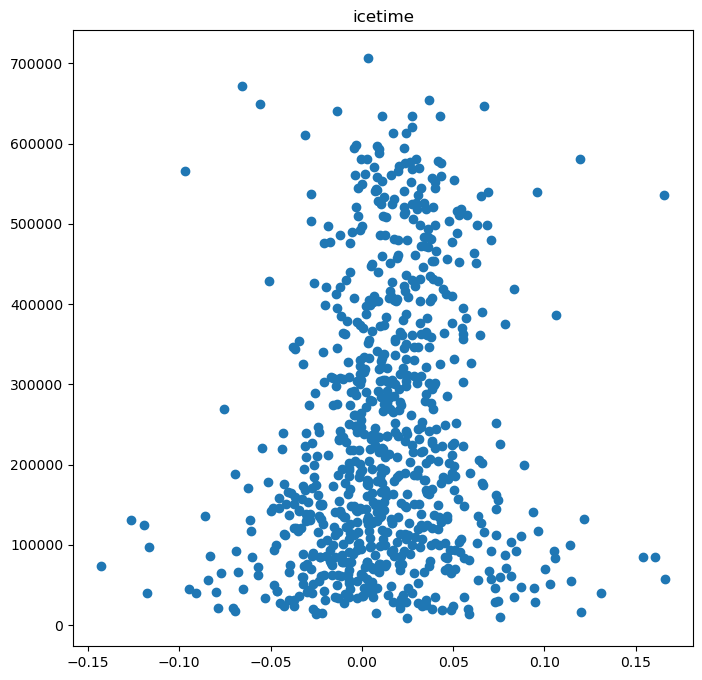

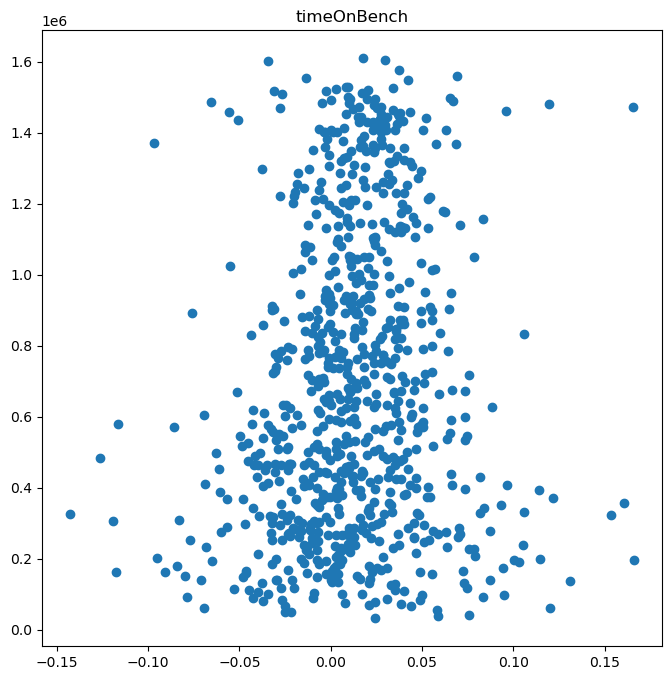

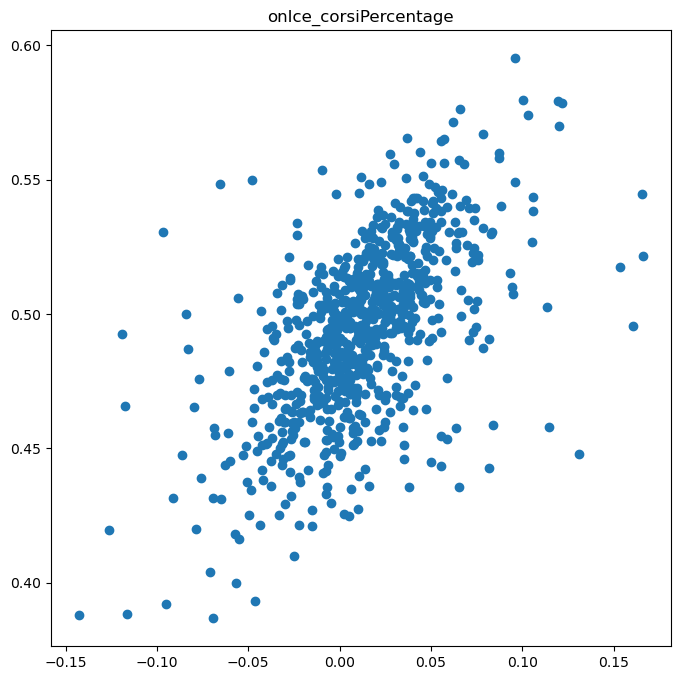

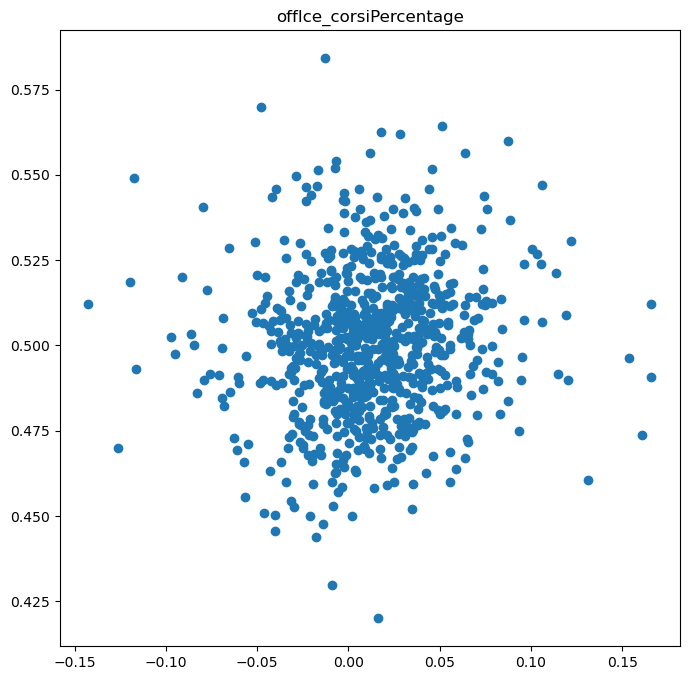

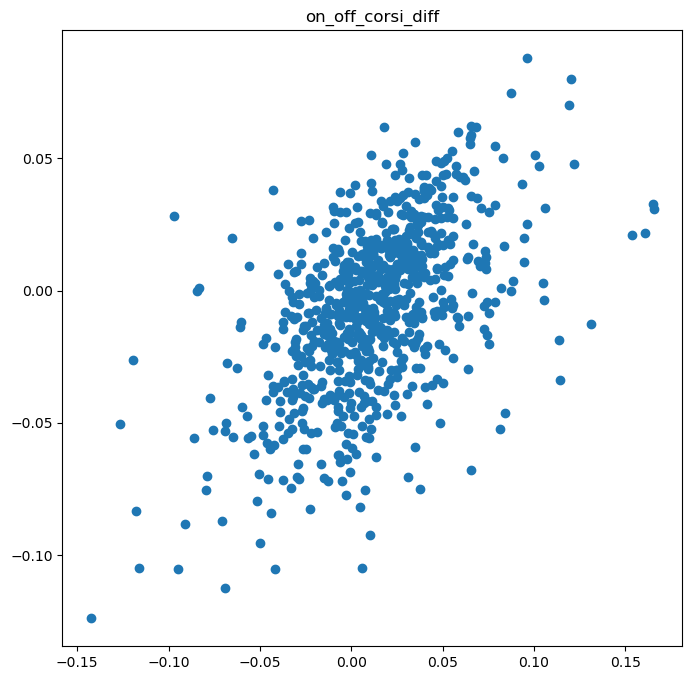

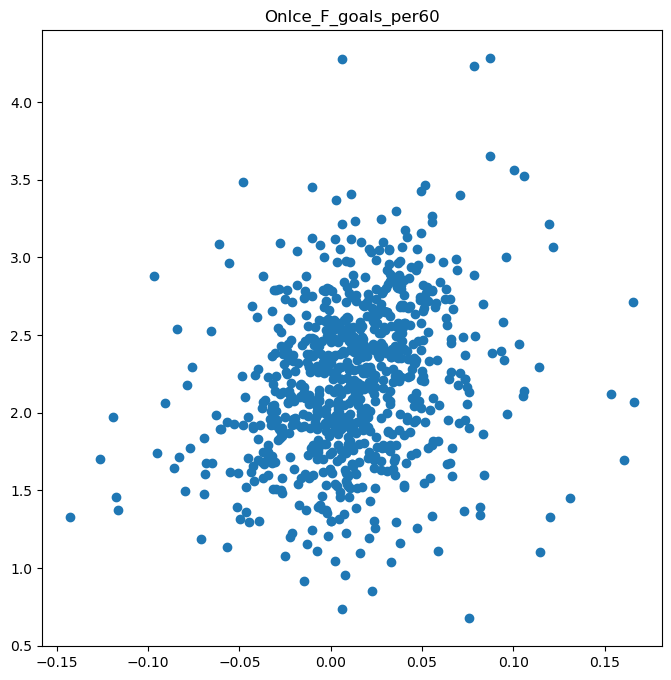

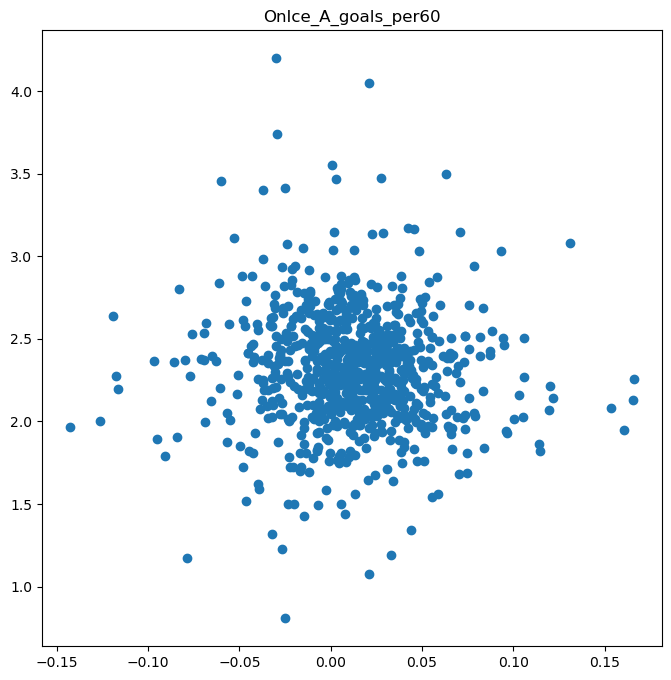

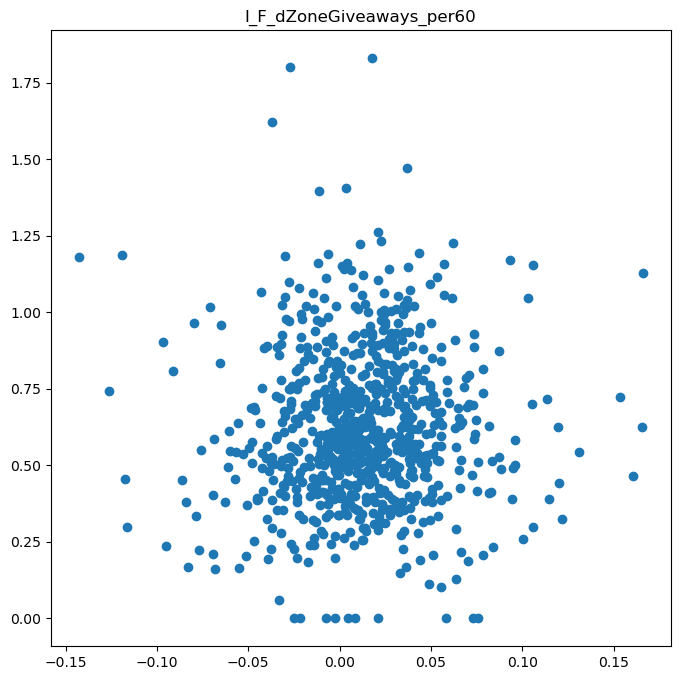

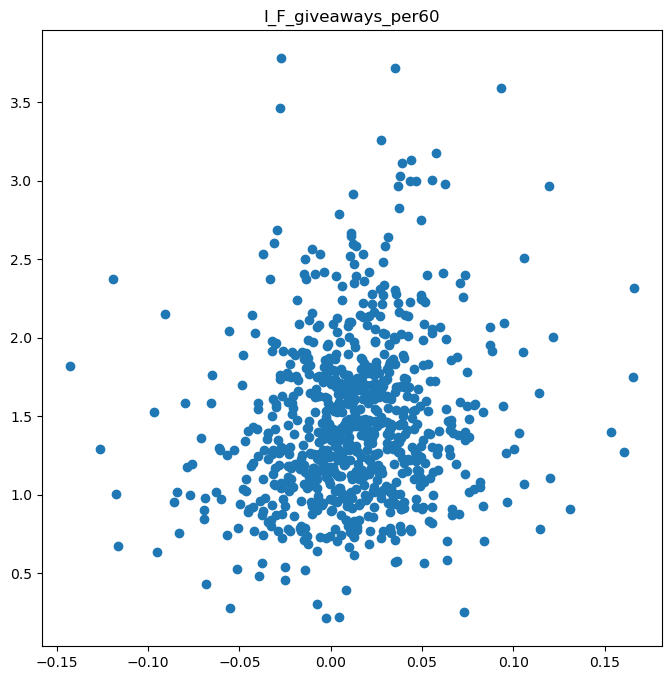

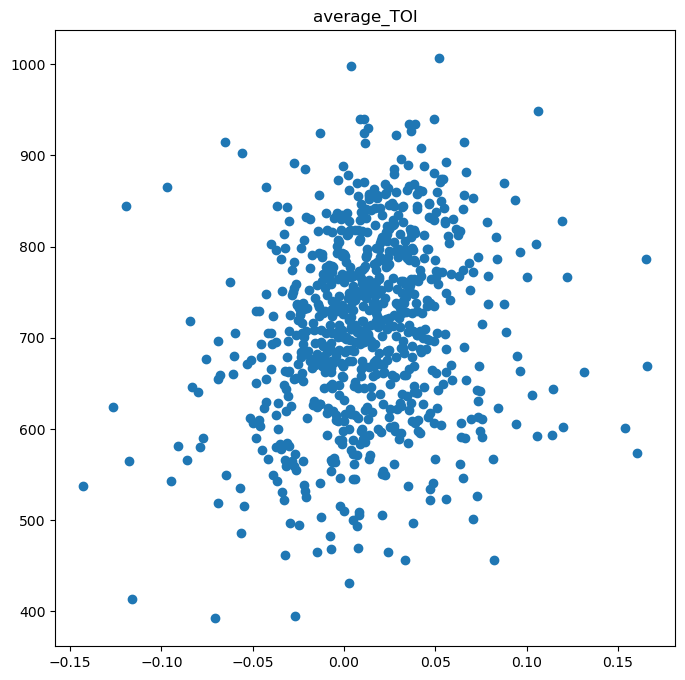

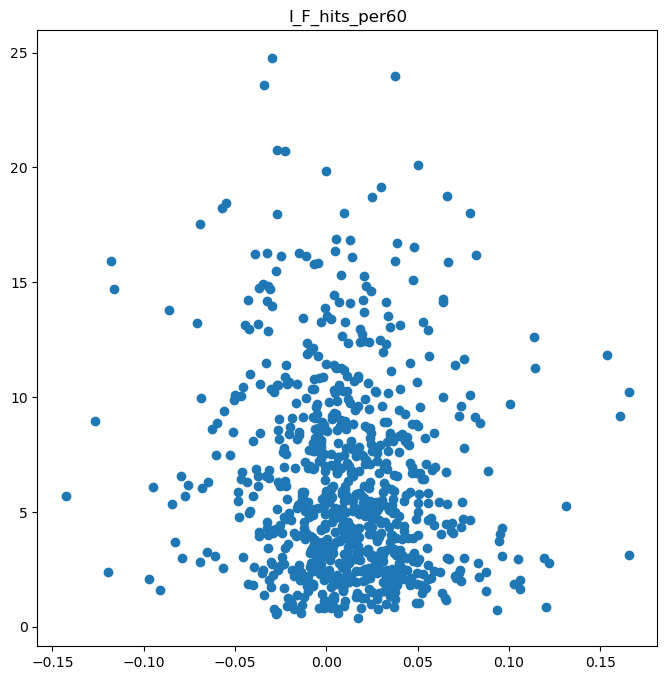

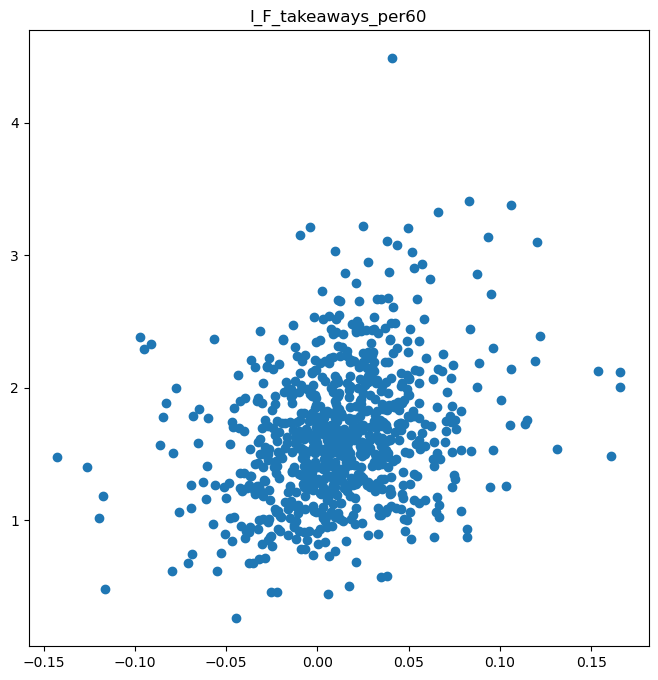

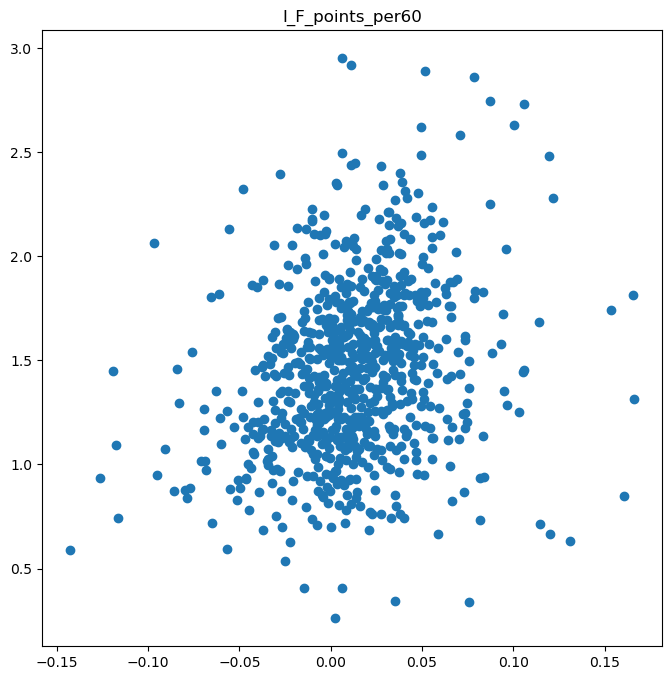

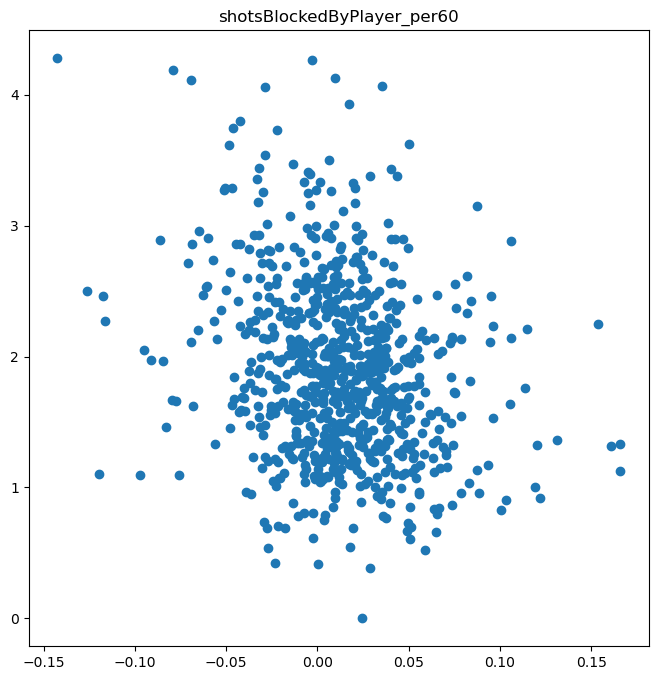

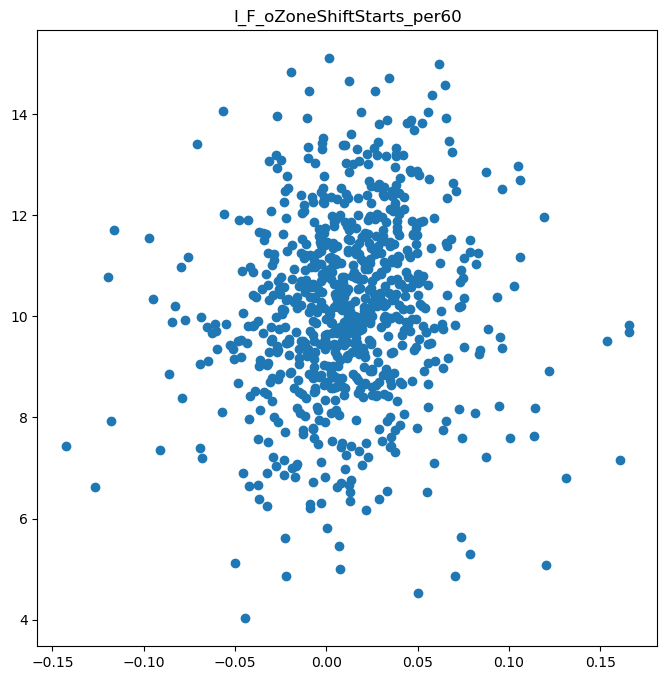

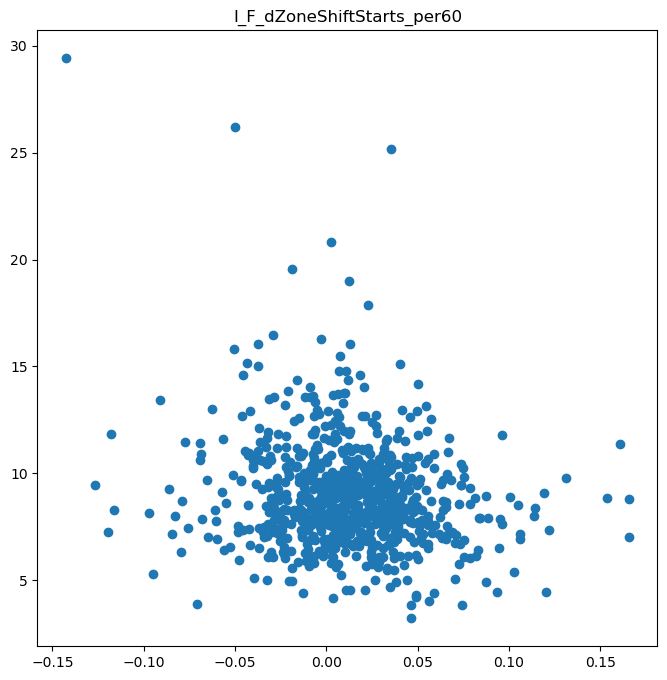

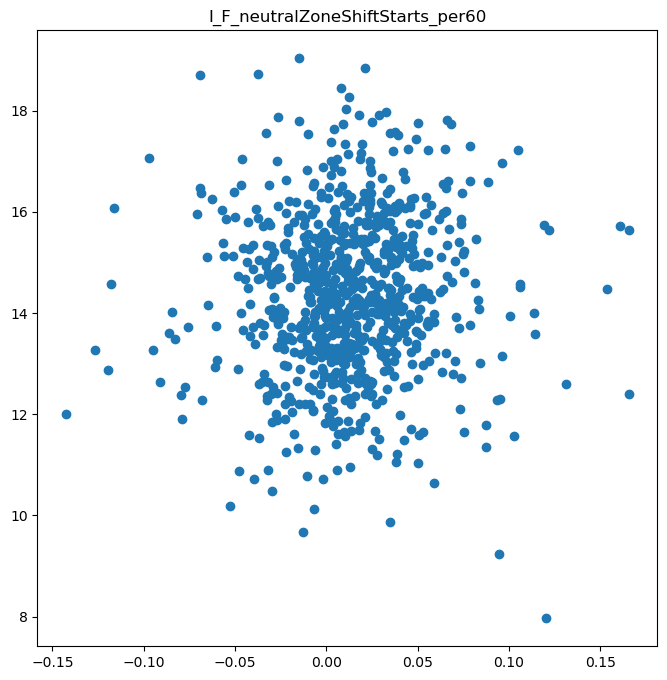

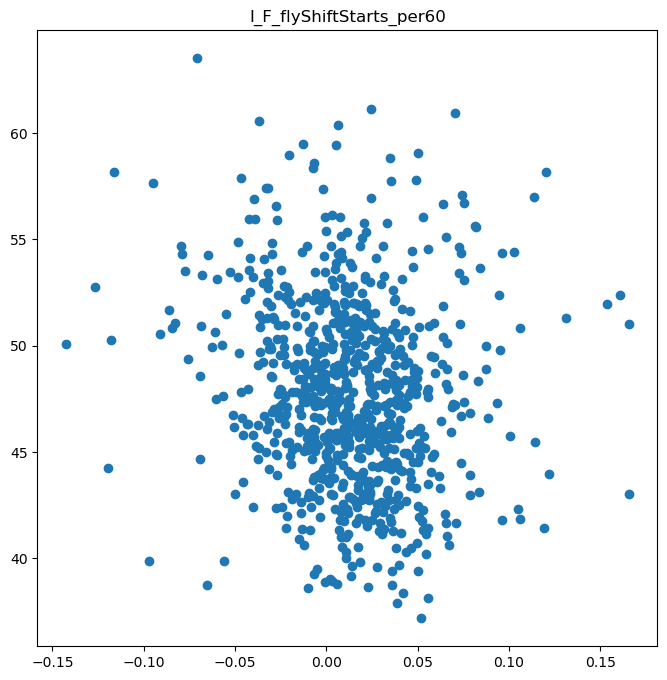

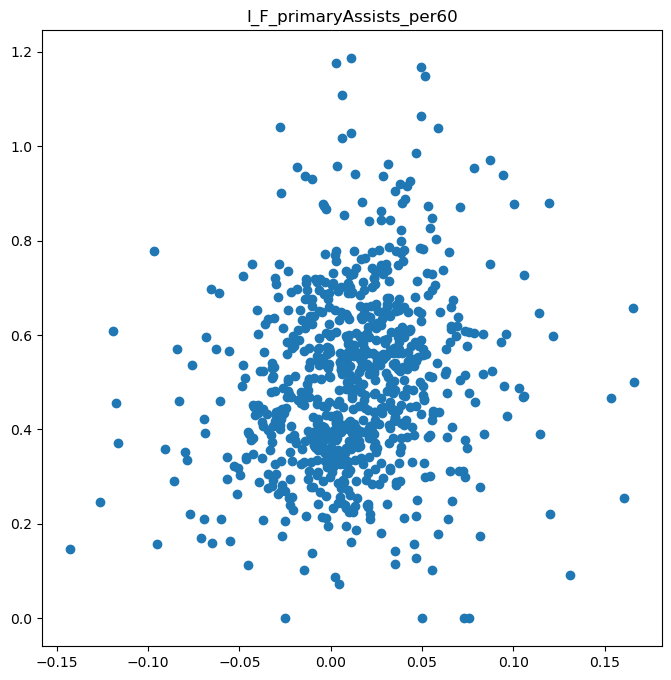

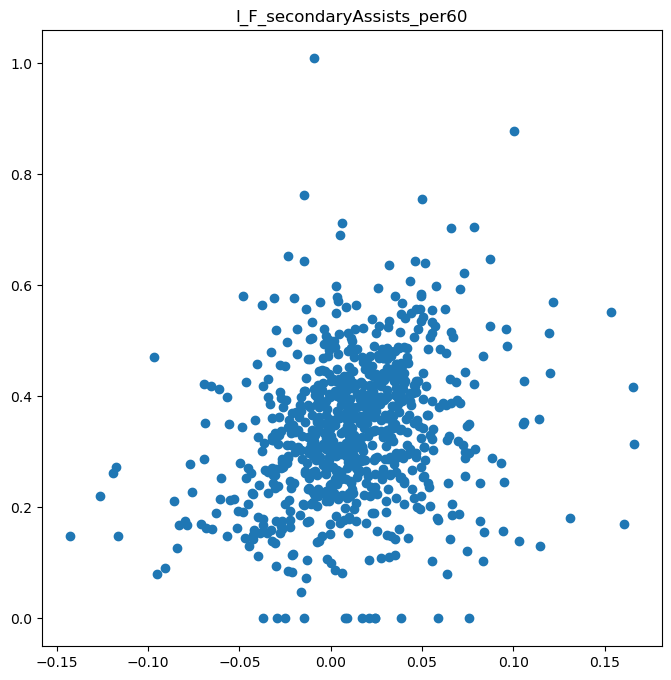

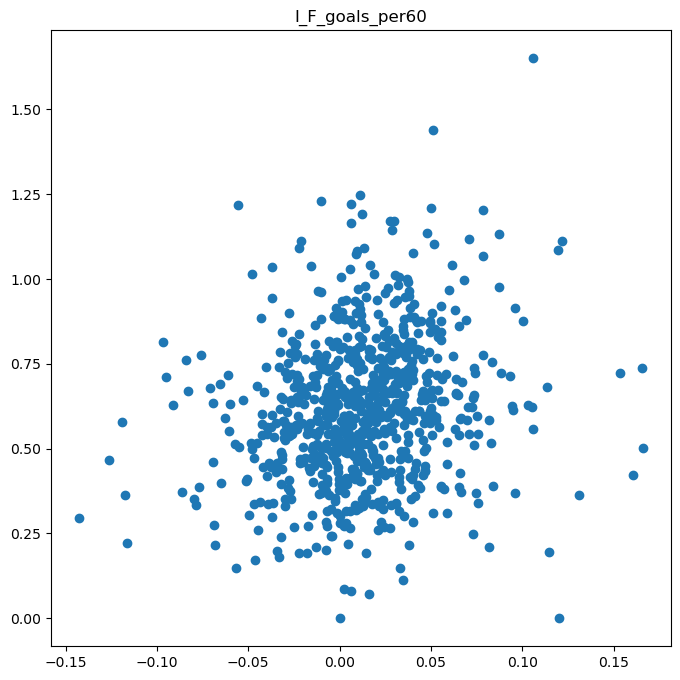

In [26]:
# Plot all interesting stats vs average influence
import matplotlib.pyplot as plt
# Chart some stats vs avg corsi influence
for stat in interesting_stats:
    if stat == 'playerName':
        continue
    fig, ax = plt.subplots()
    fig.set_size_inches(8, 8)
    ax.scatter(players_df['average_corsi_influence'], players_df[stat])
    ax.set_title(stat)
    plt.show()


In [27]:
# Numeric assortativity between nodes
def ordinal_stat_assortativity(G, players_df, stat):
    # Copy stat in question as node attribute first
    stats = copy_attr_to_nodes(G, players_df, stat)
    nx.set_node_attributes(G, stats, stat)
    return nx.numeric_assortativity_coefficient(G, attribute=stat)

# print(ordinal_stat_assortativity(G, players_df, 'onIce_corsiPercentage'))
# print(ordinal_stat_assortativity(G, players_df, 'on_off_corsi_diff'))
# print(ordinal_stat_assortativity(G, players_df, 'OnIce_F_goals_per60'))
# print(ordinal_stat_assortativity(G, players_df, 'I_F_dZoneGiveaways_per60'))
# print(ordinal_stat_assortativity(G, players_df, 'I_F_giveaways_per60'))
# print(ordinal_stat_assortativity(G, players_df, 'shotsBlockedByPlayer_per60'))
# print(ordinal_stat_assortativity(G, players_df, 'I_F_hits_per60'))
# print(ordinal_stat_assortativity(G, players_df, 'I_F_takeaways_per60'))
# print(ordinal_stat_assortativity(G, players_df, 'I_F_points_per60'))
# print(ordinal_stat_assortativity(G, players_df, 'average_TOI'))


In [28]:
import networkx.algorithms.community as nxc

# Greedy Modularity
communities = nxc.greedy_modularity_communities(G, weight='weight')

print(len(communities))

# add community info to node attributes
i = 0
communities_dict = dict.fromkeys(G.nodes)
for community in communities:
    for player in community:
        communities_dict[player] = i
    i += 1

nx.set_node_attributes(G, communities_dict, "community")
nx.write_gexf(G, 'forwards.gexf')


111
